---

В этом ноутбке мы научимся писать свои свёрточные нейросети на фреймворке PyTorch, и протестируем их работу на датасетах MNIST и CIFAR10.

**ВНИМАНИЕ:** Рассматривается ***задача классификации изображений***.

(Подразумевается, что читатель уже знаком с многослойной нейроннной сетью).  

***Свёрточная нейросеть (Convolutional Neural Network, CNN)*** - это многослойная нейросеть, имеющая в своей архитектуре помимо *полносвязных слоёв* (а иногда их может и не быть) ещё и **свёрточные слои (Conv Layers)** и **pooling-слои (Pool Layers)**.  

Собственно, название такое эти сети получили потому, что в основе их работы лежит операция **свёртки**.


Сразу же стоит сказать, что свёрточные нейросети **были придуманы прежде всего для задач, связанных с картинками**, следовательно, на вход они тоже "ожидают" картинку.

Расмотрим их устройство более подробно:

* Вот так выглядит неглубокая свёрточная нейросеть, имеющая такую архитектуру:  
`Input -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`

<img src="https://camo.githubusercontent.com/269e3903f62eb2c4d13ac4c9ab979510010f8968/68747470733a2f2f7261772e6769746875622e636f6d2f746176677265656e2f6c616e647573655f636c617373696669636174696f6e2f6d61737465722f66696c652f636e6e2e706e673f7261773d74727565" width=800, height=600>

Свёрточные нейросети (обыкновенные, есть и намного более продвинутые) почти всегда строятся по следующему правилу:  

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`  

то есть:  

1). ***Входной слой*** (batch картинок `HxWxC`)  

2). $M$ блоков (M $\ge$ 0) из свёрток и pooling-ов, причём именно в том порядке, как в формуле выше. Все эти $M$ блоков вместе называют ***feature extractor*** свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков, поверх тех, которые подаются (то есть, по аналогии с MLP, мы опять же переходим к новому признаковому пространству, однако здесь оно строится сложнее, чтем в обычных многослойных сетях, поскольку используется операция свёртки)  

3). $K$ штук FullyConnected-слоёв (с активациями). Эту часть из $K$ FC-слоёв называют ***classificator***, поскольку эти слои отвечают непосредственно за предсказание нужно класса (сейчас рассматривается задача классификации изображений).


<h3 style="text-align: center;"><b>Свёрточная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Так как мы сейчас рассматриваем **архитектуру CNN**, то, помимо этих компонент, в свёрточной нейросети можно настроить следующие вещи:  

- (в каждом ConvLayer) **размер фильтров (окна свёртки)** (`kernel_size`)
- (в каждом ConvLayer) **количество фильтров** (`out_channels`)  
- (в каждом ConvLayer) размер **шага окна свёртки (stride)** (`stride`)  
- (в каждом ConvLayer) **тип padding'а** (`padding`)  


- (в каждом PoolLayer) **размер окна pooling'a** (`kernel_size`)  
- (в каждом PoolLayer) **шаг окна pooling'а** (`stride`)  
- (в каждом PoolLayer) **тип pooling'а** (`pool_type`)  
- (в каждом PoolLayer) **тип padding'а** (`padding`)

Какими их берут обычно -- будет показано в примере ниже. По крайней мере, можете стартовать с этих настроек, чтобы понять, какое качество "из коробки" будет у простой модели.

Посмотрим, как работает CNN на MNIST'е и на CIFAR'е:

<img src="http://present5.com/presentation/20143288_415358496/image-8.jpg" width=500, height=400>

**MNIST:** это набор из 70k картинок рукописных цифр от 0 до 9, написанных людьми, 60k из которых являются тренировочной выборкой (`train` dataset)), и ещё 10k выделены для тестирования модели (`test` dataset).

In [ ]:
import torch
import torchvision
from torchvision import transforms
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import metrics
from torch.nn.modules.dropout import Dropout
import numpy as np
import seaborn as sns
import pandas as pd
import torchvision.transforms as transforms
import zipfile
from tqdm import tqdm

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False)

classes = tuple(str(i) for i in range(10))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4634977.52it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134873.95it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1270978.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4832706.44it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Сами данные лежат в полях `trainloader.dataset.train_data` и `testloader.dataset.test_data`:

In [ ]:
trainloader.dataset.train_data.shape

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [ ]:
testloader.dataset.test_data.shape

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([10000, 28, 28])

Выведем первую картинку:

In [ ]:
trainloader.dataset.train_data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Посмотрим, как она выглядит:

In [ ]:
# преобразовать тензор в np.array
numpy_img = trainloader.dataset.train_data[0].numpy()

In [ ]:
numpy_img.shape

(28, 28)

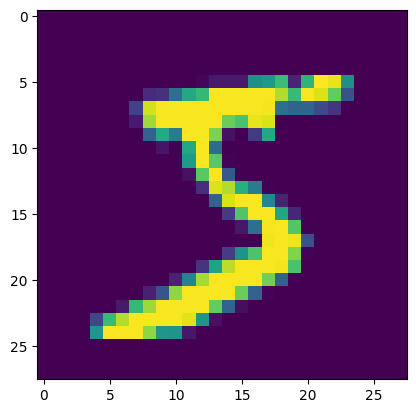

In [ ]:
plt.imshow(numpy_img);

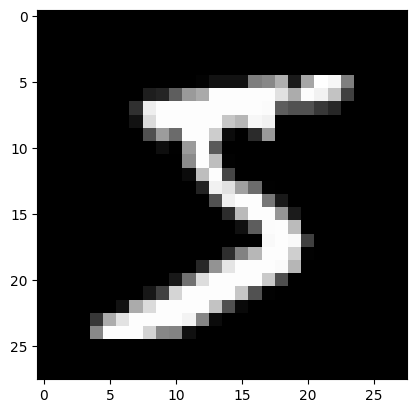

In [ ]:
plt.imshow(numpy_img, cmap='gray');

Отрисовка заданной цифры:

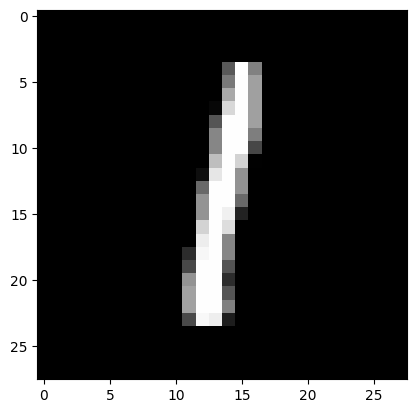

In [ ]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=60000)

plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

Как итерироваться по данным с помощью `loader'`а? Очень просто:

In [ ]:
for data in trainloader:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 10), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Теперь вернёмся к тому, что в PyTorch есть две "парадигмы" построения нейросетей -- `Functional` и `Seuquential`. Испольузем  `Functional` парадигму, потому что при построении свёрточных сетей это намного удобнее:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [ ]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 4 * 4 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**Важное примечание:** Вы можете заметить, что в строчках с `#!!!` есть не очень понятный сходу 4 `*` 4 `*` 16. Это -- размерность картинки перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную (в Keras, например, `.Flatten()` всё делает за Вас). Однако есть один *лайфхак* -- просто сделайте в `forward()` `print(x.shape)` (закомментированная строка). Вы увидите размер `(batch_size, C, H, W)` -- нужно перемножить все, кроме первого (batch_size), это и будет первая размерность `Linear()`, и именно в C * H * W нужно "развернуть" x перед подачей в `Linear()`.  

То есть нужно будет запустить цикл с обучением первый раз с `print()` и сделать после него `break`, посчитать размер, вписать его в нужные места и стереть `print()` и `break`.

Код обучения слоя:

In [ ]:
from tqdm import tqdm

In [ ]:
# объявляем сеть
net = SimpleConvNet()

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)



# # итерируемся
# for epoch in tqdm(range(3)):

#     running_loss = 0.0
#     for i, batch in enumerate(tqdm(trainloader)):
#         # так получаем текущий батч
#         X_batch, y_batch = batch

#         # обнуляем веса
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         y_pred = net(X_batch)
#         loss = loss_fn(y_pred, y_batch)
#         loss.backward()
#         optimizer.step()

#         # выведем текущий loss
#         running_loss += loss.item()
#         # выведем качество каждые 2000 батчей
#         if i % 2000 == 1999:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

print('Обучение закончено')

 34%|███▍      | 2034/6000 [00:12<00:22, 173.17it/s]

[1,  2000] loss: 0.869



 67%|██████▋   | 4034/6000 [00:25<00:11, 177.27it/s]

[1,  4000] loss: 0.331



 33%|███▎      | 1/3 [00:38<01:16, 38.32s/it]

[1,  6000] loss: 0.276



 34%|███▎      | 2021/6000 [00:13<00:23, 166.38it/s]

[2,  2000] loss: 0.211



 67%|██████▋   | 4019/6000 [00:26<00:11, 177.04it/s]

[2,  4000] loss: 0.173



 67%|██████▋   | 2/3 [01:17<00:38, 38.56s/it]

[2,  6000] loss: 0.157



 34%|███▎      | 2023/6000 [00:12<00:26, 151.02it/s]

[3,  2000] loss: 0.131



 41%|████      | 2459/6000 [00:15<00:19, 180.46it/s]


Протестируем на всём тестовом датасете, используя метрику accuracy_score:

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 97 %
Accuracy of     2 : 98 %
Accuracy of     3 : 96 %
Accuracy of     4 : 98 %
Accuracy of     5 : 96 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 97 %
Accuracy of     9 : 91 %


Два свёрточных слоя побили многослойную нейросеть. Не магия ли?

---

### Задача 1

Протестируйте эту нейросеть на отдельных картинках из тестового датасета: напишите функцию, которая принимает индекс картинки в тестовом датасете, отрисовывает её, потом запускает на ней модель (нейросеть) и выводит результат предсказания.

In [ ]:
def predict_on_test_example(idx):

    img, label = testset[idx]
    plt.imshow(img.squeeze().numpy())
    y_pred = net(img.unsqueeze(dim=0))
    _, predicted = torch.max(y_pred, 1)
    print(f'Модель предсказала класс {predicted.item()}')

Модель предсказала класс 1


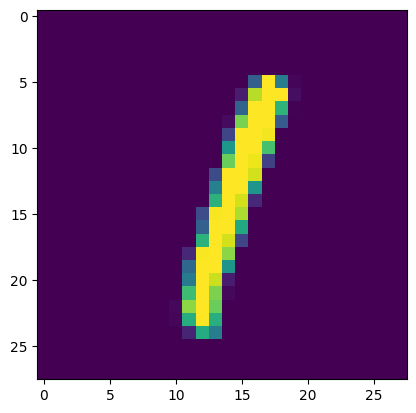

In [ ]:
predict_on_test_example(5);

---

<h3 style="text-align: center;"><b>CIFAR10</b></h3>

<img src="https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png" width=500, height=400>

**CIFAR10:** это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именн он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='D:/nvb/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='D:/nvb//data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:15<00:00, 10744980.29it/s]


Extracting D:/nvb/data/cifar-10-python.tar.gz to D:/nvb/data
Files already downloaded and verified


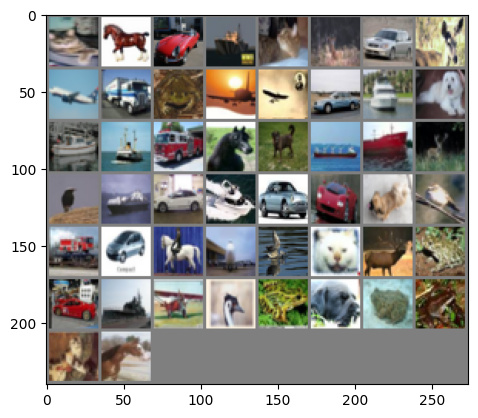

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Функция, которая показывает изображения
def imshow(img):
    img = img / 2 + 0.5     # деномрировка
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# достаем случайные картинки из обучающей выборки
dataiter = iter(trainloader)
images, labels = next(dataiter)

# вызываем функцию, реализующую демонстрацию изображений, что мы можем видеть на них?
imshow(torchvision.utils.make_grid(images))

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 20), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Данные готовы, мы даже на них посмотрели. **Однако учтите** - при подаче в нейросеть мы будем разворачивать картинку 32х32х3 в строку 1х(32`*`32`*`3) = 1х3072, то есть мы считаем пиксели (значения интенсивности в пикселях) за признаки нашего объекта (картинки).  

К делу:

### Задача 2

Напишите свою свёрточную нейросеть для предсказания на CIFAR10.

In [ ]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) # -> 6x28x28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # -> 6x14x14
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # -> 16x10x10
        self.fc1 = nn.Linear(16 * 10 * 10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # Применение функции активации ReLU после первого сверточного слоя
        x = self.pool(x) # Применение слоя MaxPooling
        x = F.relu(self.conv2(x)) # Применение функции активации ReLU после второго сверточного слоя
        x = x.view(-1, 16 * 10 * 10) # Преобразование тензора для подключения к полносвязному слою
        x = F.relu(self.fc1(x)) # Применение функции активации ReLU после первого полносвязного слоя
        x = F.relu(self.fc2(x)) # Применение функции активации ReLU после второго полносвязного слоя
        x = self.fc3(x) # Применение третьего полносвязного слоя (выходной слой)
        return x

    # def forward(self, x):
    #     x = x.unsqueeze(dim=1)
    #     x = self.pool(F.relu(self.conv1(x)))
    #     x = self.pool(F.relu(self.conv2(x)))
    #     x = x.view(-1, 16 * 765)
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = self.fc3(x)
    #     return x

Обучим:

In [ ]:
from tqdm import tqdm

In [ ]:
import torch

# Создаем тензор с размерами [50, 1, 3, 32, 32]
tensor = torch.randn(50, 1, 3, 32, 32)

tensor.view(batch_size, 3, 32 * 32).shape

# Преобразуем тензор в размерности [50, 3, 32, 32] с помощью метода squeeze()
# tensor_new = tensor.squeeze(1)

# # Проверяем размерности нового тензора
# print(tensor_new.shape)

torch.Size([50, 3, 1024])

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cuda



In [ ]:
def train_model(model, train_dataLoader, dimensions, loss_f, optimizer, n_epochs, log_interval, batch_size, device='cpu'):
    model.train()

    losses = []

    for epoch in range(n_epochs):
        loss_total = 0
        for i,(X, y) in enumerate(train_dataLoader):
            X = X.to(device, dtype=torch.float32)
            y = y.to(device)

            optimizer.zero_grad()

            y_pred = model.forward(X.view(*dimensions))

            loss = loss_f(y_pred,y)
            loss.backward()
            optimizer.step()
            loss_total += loss.item()

            if (i + 1) % log_interval == 0:
                print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f'
                    %(epoch+1, n_epochs, i+1, len(train_dataLoader.dataset)//batch_size, loss.item()))

        losses.append(loss_total / len(train_dataLoader))

    return losses


def get_accuracy(model, X, y):
    y_pred = model.forward(X).argmax(dim=1, keepdim=True)
    accuracy = metrics.accuracy_score(y, y_pred.detach().numpy())
    return accuracy

def show_err_matrix(class_names, y, y_pred):
    fig, ax = plt.subplots(figsize=(10, 8))
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names)
    plt.yticks(ticks, class_names)

    confusion_matrix = metrics.confusion_matrix(y, y_pred)
    sns.heatmap(pd.DataFrame(confusion_matrix), annot=True)


def show_img_with_labels(X, y, y_pred):
    img_n = 0
    img_row = 5
    img_col = 6
    img_qty = img_row * img_col

    data1_part = X[img_n:img_n+img_qty, :, :]
    target1_part = y[img_n:img_n+img_qty]

    fig = plt.figure(figsize=(14,12))

    for i in range(img_qty):
        plt.subplot(img_row, img_col, i+1)
        plt.tight_layout()
        plt.imshow(data1_part[i], cmap='gray', interpolation='none')
        if y_pred[i].item() == target1_part[i]:
            plt.title(f"pr: {y_pred[i].item()} tgt: {target1_part[i]}")
        else:
            plt.title(f"ERR: pr: {y_pred[i].item()} tgt: {target1_part[i]}")
        plt.xticks([])
        plt.yticks([])


def validate(model, test_dataLoader):
  model.eval()

  y_pred_list = []
  y_list = []
  X_list = []

  right = 0

  for _,(X, y) in enumerate(test_dataLoader):
    # X = X.to(device)
    # y = y.to(device)

    y_pred = model.forward(X).argmax(dim=1)
    y_pred_list.append(y_pred.detach().numpy())
    y_list.append(y.numpy())
    X_list.append(X.numpy())

    right += (y_pred == y).sum()

  y_pred = np.concatenate(y_pred_list)
  y = np.concatenate(y_list)
  X = np.concatenate(X_list).transpose((0,2,3,1))


  print(f'Test accuracy: {right / len(test_dataLoader.dataset)}')
  show_img_with_labels(X, y, y_pred)
  show_err_matrix(test_dataLoader.dataset.classes, y, y_pred)


****************************** Обучение модели ******************************
Epoch : 1/5, Iter : 100/1000,  Loss: 1.8537
Epoch : 1/5, Iter : 200/1000,  Loss: 1.8317
Epoch : 1/5, Iter : 300/1000,  Loss: 1.5713
Epoch : 1/5, Iter : 400/1000,  Loss: 1.6488
Epoch : 1/5, Iter : 500/1000,  Loss: 1.5354
Epoch : 1/5, Iter : 600/1000,  Loss: 1.3824
Epoch : 1/5, Iter : 700/1000,  Loss: 1.6259
Epoch : 1/5, Iter : 800/1000,  Loss: 1.8255
Epoch : 1/5, Iter : 900/1000,  Loss: 1.4705
Epoch : 1/5, Iter : 1000/1000,  Loss: 1.3275
Epoch : 2/5, Iter : 100/1000,  Loss: 1.2302
Epoch : 2/5, Iter : 200/1000,  Loss: 1.4835
Epoch : 2/5, Iter : 300/1000,  Loss: 1.3285
Epoch : 2/5, Iter : 400/1000,  Loss: 1.0059
Epoch : 2/5, Iter : 500/1000,  Loss: 1.3994
Epoch : 2/5, Iter : 600/1000,  Loss: 1.2922
Epoch : 2/5, Iter : 700/1000,  Loss: 1.5576
Epoch : 2/5, Iter : 800/1000,  Loss: 1.4118
Epoch : 2/5, Iter : 900/1000,  Loss: 1.1538
Epoch : 2/5, Iter : 1000/1000,  Loss: 1.3268
Epoch : 3/5, Iter : 100/1000,  Loss: 1.1

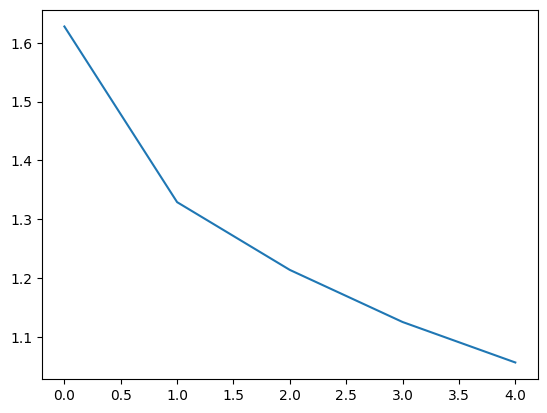

In [ ]:
net = MyConvNet()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

print("*"*30, "Обучение модели", "*"*30)
losses = train_model(net, trainloader, (batch_size, 3, 32, 32), loss_f, optimizer, 5, 100, batch_size)
print("*"*30, "FINISHED", "*"*30)

plt.plot(losses)

Test accuracy: 0.5982999801635742


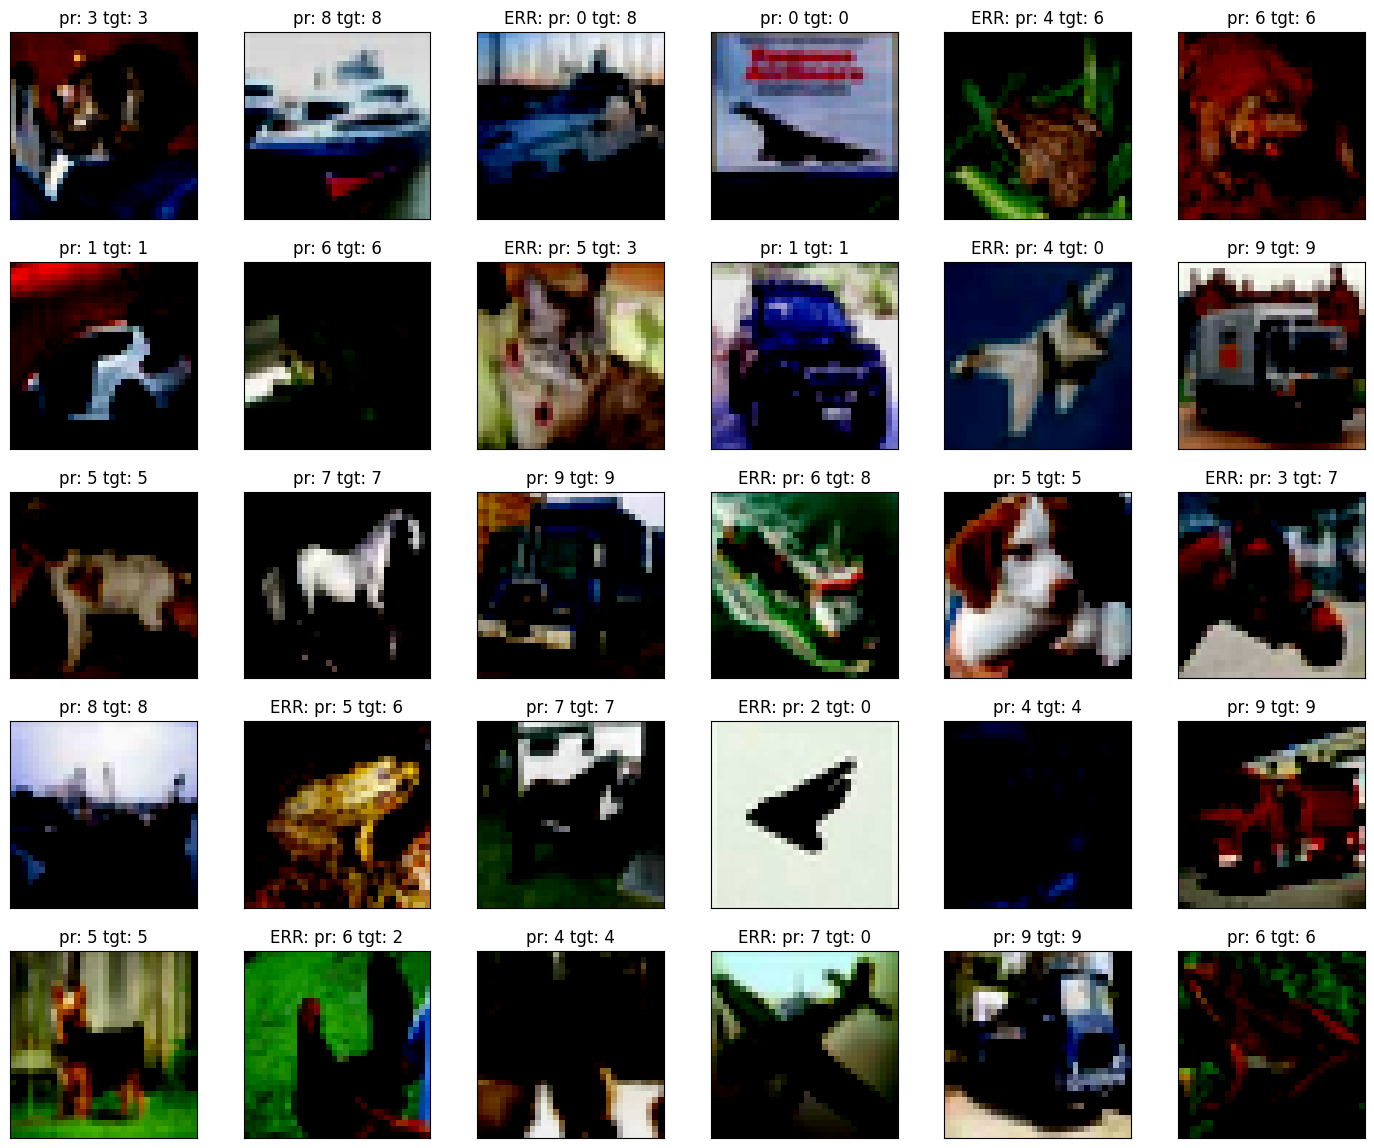

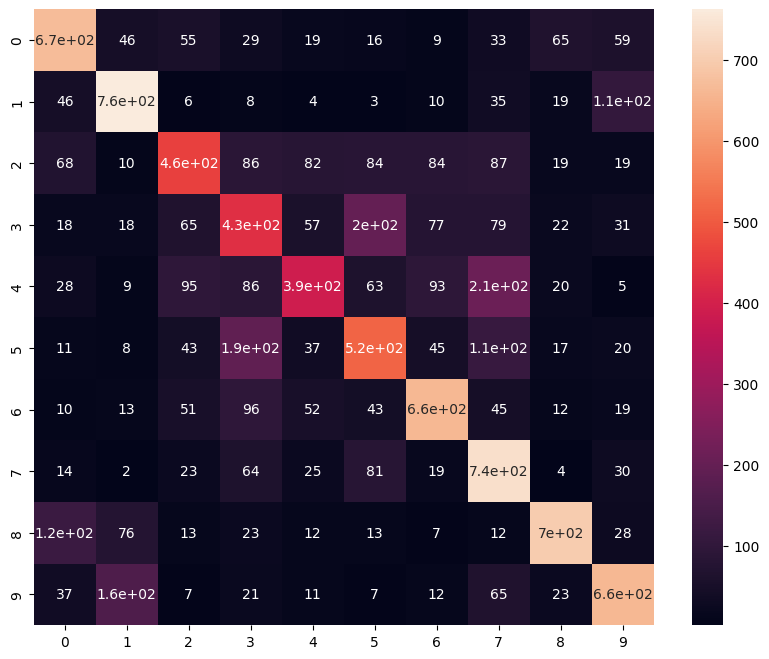

In [ ]:
validate(net, testloader)

Посмотрим на accuracy на тестовом датасете:

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images.view(batch_size, 3, 32, 32))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 80 %
Accuracy of  bird : 43 %
Accuracy of   cat : 41 %
Accuracy of  deer : 39 %
Accuracy of   dog : 45 %
Accuracy of  frog : 61 %
Accuracy of horse : 76 %
Accuracy of  ship : 69 %
Accuracy of truck : 61 %


In [ ]:
mean_accuracy = np.mean([class_correct[i] / class_total[i] for i in range(10)])
mean_accuracy

0.5948514287263065

Как думаете, этого достаточно?

### Задача 3  

Улучшите свёрточную нейросеть: поэкспериментируйте с архитектурой (количество слоёв, порядок слоёв), с гиперпараметрами слоёв (размеры kernel_size, размеры pooling'а, количество kernel'ов в свёрточном слое) и с гиперпараметрами, указанными в "Компоненты нейросети" (см. памятку выше).

In [ ]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class MyConvNet3(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.pool =  nn.MaxPool2d(kernel_size=2, stride=2)
        self.norm128 = nn.BatchNorm2d(128)
        self.norm32 = nn.BatchNorm2d(32)
        self.dropout2d = nn.Dropout2d(p=0.05)
        self.dropout = nn.Dropout(p=0.1)

        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)


    def forward(self, x):

        x = self.pool(F.relu(self.norm32(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.norm128(self.conv3(x))))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

****************************** Обучение модели ******************************
Epoch : 1/5, Iter : 100/1000,  Loss: 1.7407
Epoch : 1/5, Iter : 200/1000,  Loss: 1.6190
Epoch : 1/5, Iter : 300/1000,  Loss: 1.2959
Epoch : 1/5, Iter : 400/1000,  Loss: 1.1725
Epoch : 1/5, Iter : 500/1000,  Loss: 1.2511
Epoch : 1/5, Iter : 600/1000,  Loss: 1.2770
Epoch : 1/5, Iter : 700/1000,  Loss: 1.5361
Epoch : 1/5, Iter : 800/1000,  Loss: 1.0704
Epoch : 1/5, Iter : 900/1000,  Loss: 1.1650
Epoch : 1/5, Iter : 1000/1000,  Loss: 0.9784
Epoch : 2/5, Iter : 100/1000,  Loss: 0.9313
Epoch : 2/5, Iter : 200/1000,  Loss: 0.8880
Epoch : 2/5, Iter : 300/1000,  Loss: 1.0098
Epoch : 2/5, Iter : 400/1000,  Loss: 0.8829
Epoch : 2/5, Iter : 500/1000,  Loss: 0.7948
Epoch : 2/5, Iter : 600/1000,  Loss: 0.8905
Epoch : 2/5, Iter : 700/1000,  Loss: 0.7734
Epoch : 2/5, Iter : 800/1000,  Loss: 0.8181
Epoch : 2/5, Iter : 900/1000,  Loss: 0.6877
Epoch : 2/5, Iter : 1000/1000,  Loss: 0.6023
Epoch : 3/5, Iter : 100/1000,  Loss: 0.8

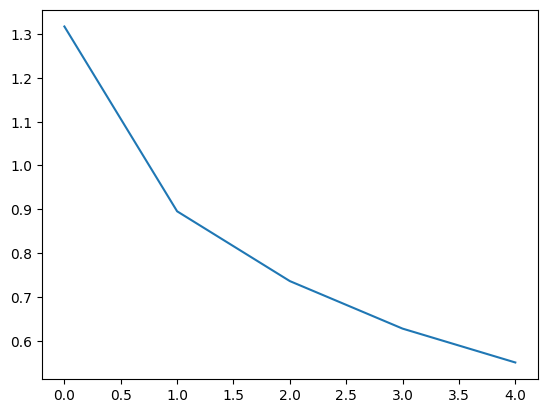

In [ ]:
net = MyConvNet3()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

print("*"*30, "Обучение модели", "*"*30)
losses = train_model(net, trainloader, (batch_size, 3, 32, 32), loss_f, optimizer, 5, 100, batch_size)
print("*"*30, "FINISHED", "*"*30)

plt.plot(losses)

(Ожидаемый результат -- скорее всего, сходу Вам не удастся выжать из Вашей сетки больше, чем ~70% accuracy (в среднем по всем классам). Если это что-то в этом районе - Вы хорошо постарались).

In [ ]:
validate()

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 91 %
Accuracy of   car : 86 %
Accuracy of  bird : 71 %
Accuracy of   cat : 44 %
Accuracy of  deer : 78 %
Accuracy of   dog : 70 %
Accuracy of  frog : 88 %
Accuracy of horse : 80 %
Accuracy of  ship : 79 %
Accuracy of truck : 77 %


In [ ]:
mean_accuracy = np.mean([class_correct[i] / class_total[i] for i in range(10)])
mean_accuracy

0.769243761133095

Test accuracy: 0.7678999900817871


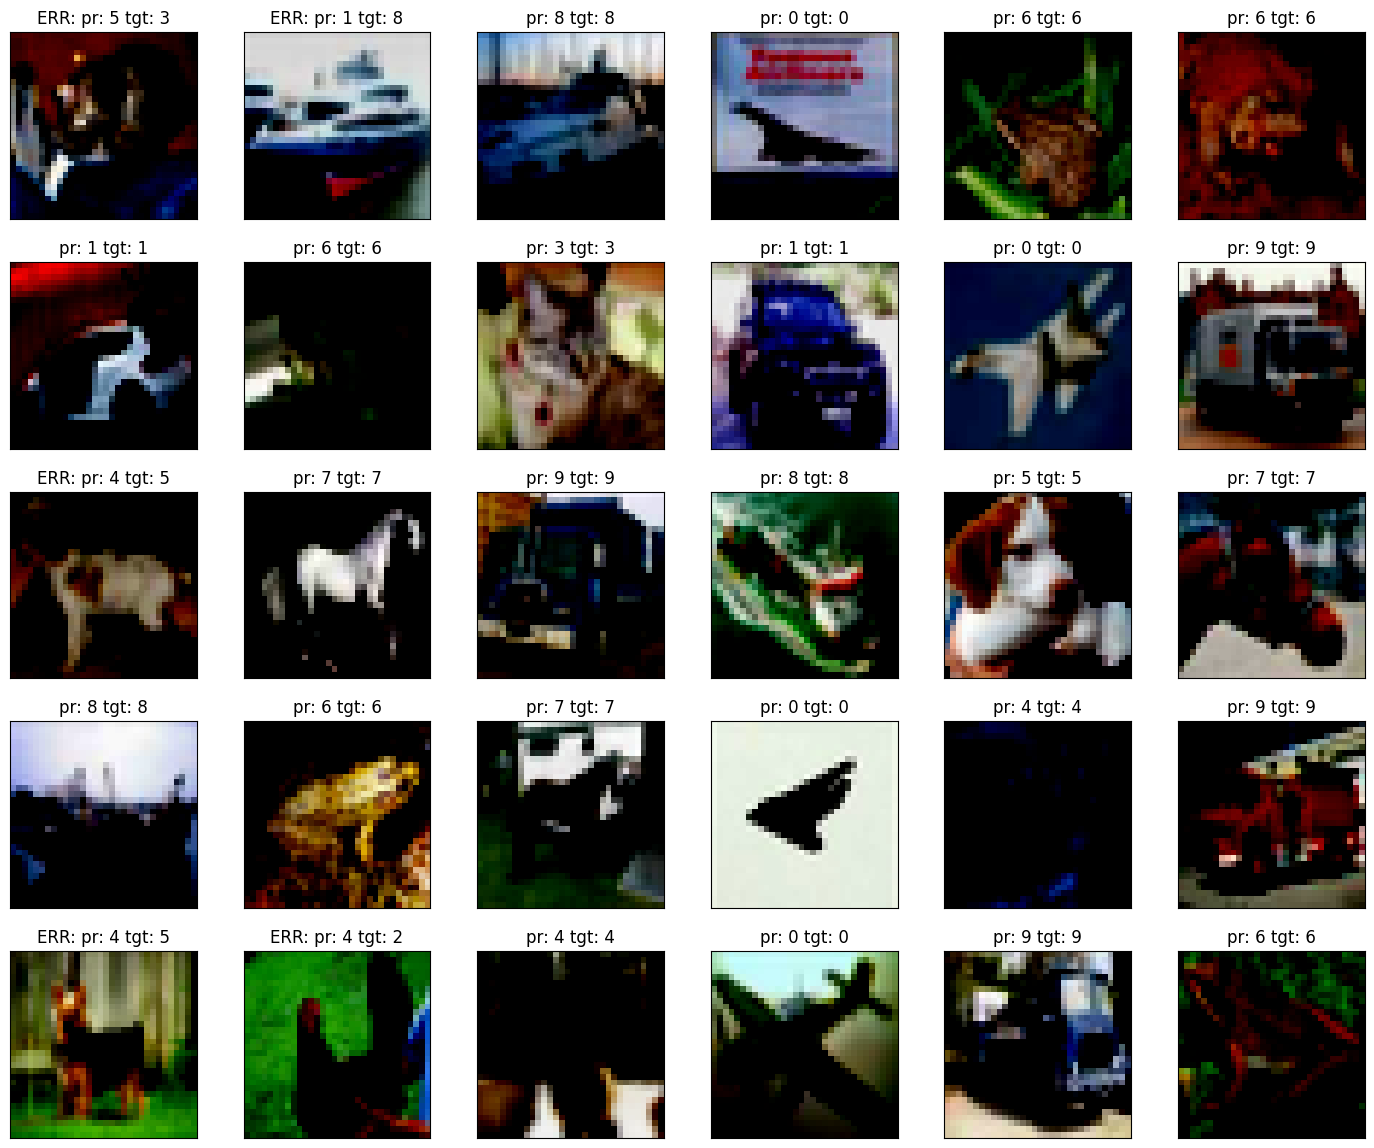

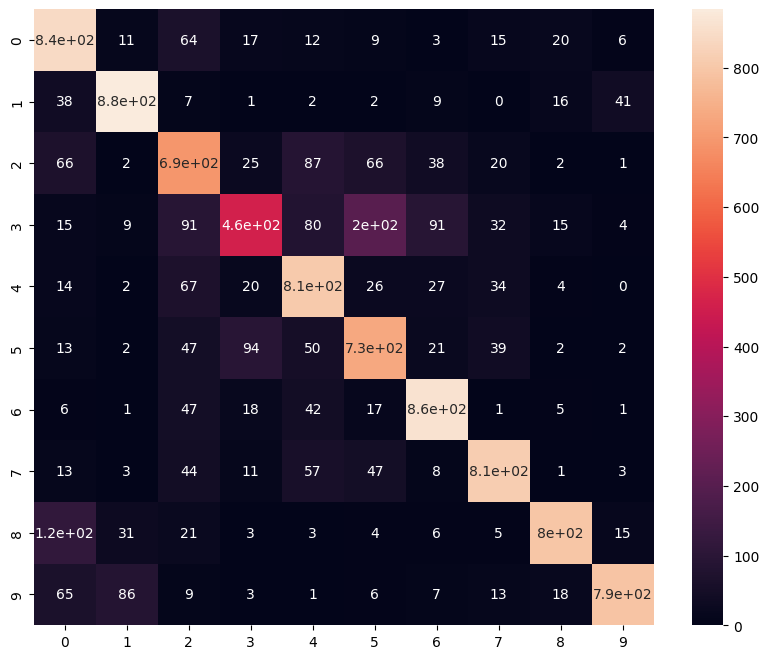

In [ ]:
validate(net, testloader)

__неплохо получилось, с 56% до 76% точности в среднем по всем классам__

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам свёрточных нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/convolutional-networks/  
http://cs231n.github.io/understanding-cnn/  
http://cs231n.github.io/transfer-learning/

4). Видео о Computer Vision от Andrej Karpathy: https://www.youtube.com/watch?v=u6aEYuemt0M